In [419]:
#local設定
local_deployment = True

if local_deployment:
    input_path = "../input/lec_5_loan_condition"
    #input_path = "../input/"
else:
    input_path = "/kaggle/input/exam-for-students20200923"

In [183]:
df_tr = pd.DataFrame({'A':['cat','dog','amko',np.nan],'B':[0,1,np.nan,np.nan],'C':[0,np.nan,0,22]})
#df_te = pd.DataFrame({'A':['cat','tim','pam'],'B':[0,1,22]})

In [187]:
df_tr = pd.DataFrame({'A':['cat','dog','amko',np.nan],'B':['10s','100s','01s',np.nan],'C':[0,np.nan,0,22]})

In [188]:
df_tr

,A,B,C
0,cat,10s,0.0
1,dog,100s,NaN
2,amko,01s,0.0
3,NaN,NaN,22.0


In [189]:
enc_label(df_tr,'B')

(      A     B     C  B_label
 0   cat   10s   0.0        2
 1   dog  100s   NaN        1
 2  amko   01s   0.0        0
 3   NaN   NaN  22.0        3,
 ['B_label'])

In [373]:
import numpy as np
import scipy as sp
import pandas as pd
from pandas import DataFrame, Series

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold,KFold,GroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from category_encoders import OrdinalEncoder, OneHotEncoder, TargetEncoder
from tqdm.notebook import tqdm
#from tqdm import tqdm #loacl
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder, QuantileTransformer

import seaborn as sns
sns.set()

import gc
from scipy.sparse import csr_matrix
#display
pd.set_option('display.max_columns', 500)

In [2]:
def datetime_convert(df,cols):
    for col in cols:
        df[col] = pd.to_datetime(df[col])
    return df

In [39]:
def concat_dffull(target_col,df_train,df_test):
    y_train = df_train[target_col]
#     X_train = df_train.drop([target_col], axis=1)
#     X_test = df_test.copy()
    #ID 分割で使用する
    train_index,test_index = df_train.index,df_test.index
    
    df_full = pd.concat([df_train,df_test],sort=False)
    df_full.drop([target_col],axis=1,inplace=True)
    
    return df_full,y_train,train_index,test_index

def unconcat_dffull(df_full,train_index,test_index):
    X_train = df_full.loc[train_index]
    X_test  = df_full.loc[test_index]
    return X_train,X_test

In [329]:
# def cat_num_cols(X_test,id_col,nunique_counts=100,): #,id_col='ID'
#     cat1_cols = [c for c in X_test.columns if X_test[c].nunique() <nunique_counts and 
#                         X_test[c].dtype in [np.object] and c not in [id_col]]
#     cat2_cols = [c for c in df_test.columns if X_test[c].nunique() >=nunique_counts and 
#                         X_test[c].dtype in [np.object] and c not in [id_col]]
#     num_cols = [c for c in X_test.columns if X_test[c].dtype in [np.float, 'int64','int32'] ] #and c not in [id_col]
#     #datetime_cols = [c for c in X_test.columns if X_test[c].dtype in ['datetime64[ns]'] and c not in [id_col]]

#     print("Total cat/num number of features:", len(cat1_cols)+len(num_cols) + len(cat2_cols) )
#     #print("Pipline number of features:", len(cat1_cols)+len(num_cols))
#     print('cat1 of features:',len(cat1_cols))
#     print(f'cat2 over nuniques {nunique_counts} of features:',len(cat2_cols))
#     print('num_cols of features:',len(num_cols))
#     print("-"*30)
#     print('cat1\n', cat1_cols)
#     print('cat2\n',cat2_cols)
#     print('num\n',num_cols)
    
#     return cat1_cols,cat2_cols,num_cols #datetime_cols

In [320]:
def cat_num_cols(X_test,un_cols,nunique_counts=100,): #,id_col='ID'
    cat1_cols = [c for c in X_test.columns if X_test[c].nunique() <nunique_counts and 
                        X_test[c].dtype in [np.object] and c not in un_cols]
    cat2_cols = [c for c in df_test.columns if X_test[c].nunique() >=nunique_counts and 
                        X_test[c].dtype in [np.object] and c not in un_cols]
    num_cols = [c for c in X_test.columns if X_test[c].dtype in [np.float, 'int64','int32'] and c not in un_cols] 

    print("Total cat/num number of features:", len(cat1_cols)+len(num_cols) + len(cat2_cols) )
    #print("Pipline number of features:", len(cat1_cols)+len(num_cols))
    print('cat1 of features:',len(cat1_cols))
    print(f'cat2 over nuniques {nunique_counts} of features:',len(cat2_cols))
    print('num_cols of features:',len(num_cols))
    print("-"*30)
    print('cat1\n', cat1_cols)
    print('cat2\n',cat2_cols)
    print('num\n',num_cols)
    
    return cat1_cols,cat2_cols,num_cols #datetime_cols

In [5]:
def add_nan_count(df): #欠損数 特徴量追加 
    df = df.copy()
    temp = df.isnull().sum()
    cols_nan = list(temp[temp != 0].index)
    df['nan_counts'] = df.isnull().sum(axis=1)
    return df

In [6]:
def enc_label(df,cat_cols): #LGBM ラベルエンコーディング 
    df = df.copy()
    enc_label_cols =[]
    for col in cat_cols:
        enc_label_cols.append(col+'_label')
        lbl = LabelEncoder()
        df[col+'_label'] = lbl.fit_transform(list(df[col].values))
    return df,enc_label_cols

In [7]:
def enc_count(df,cat_cols): #LGBM カウントエンコーディング 
    df = df.copy()
    enc_count_cols =[]
    for col in cat_cols:
        enc_count_cols.append(col+'_ct')
        summary = df[col].value_counts()
        df[col+'_ct'] =  df[col].map(summary)
    return df,enc_count_cols

In [58]:
def enc_target(target_col,df_full,cols_cat,train_index,test_index):    # Target Encoding
    X_train = df_full.loc[train_index]
    X_test  = df_full.loc[test_index]
    X_temp = pd.concat([X_train, y_train], axis=1)
    te_enc_cols = []
    
    for col in cols_cat:
        te_enc_cols.append(col+'_te')
        
        # X_testはX_trainでエンコーディングする
        summary = X_temp.groupby([col])[target_col].mean()
        X_test[col+'_te'] = X_test[col].map(summary) 

        # X_trainのカテゴリ変数をoofでエンコーディングする
        skf = StratifiedKFold(n_splits=5, random_state=71, shuffle=True)
        enc_train = Series(np.zeros(len(X_train)), index=X_train.index)

        for i, (train_ix, val_ix) in enumerate((skf.split(X_train, y_train))):
            X_train_, _ = X_temp.iloc[train_ix], y_train.iloc[train_ix]
            X_val, _ = X_temp.iloc[val_ix], y_train.iloc[val_ix]

            summary = X_train_.groupby([col])[target_col].mean()
            enc_train.iloc[val_ix] = X_val[col].map(summary)

        X_train[col+'_te']  = enc_train
    df_full = pd.concat([X_train, X_test],sort=False)
    #df_full[te_enc_cols] = df_full[te_enc_cols].fillna(-99999) #欠損処理しない
    return df_full,te_enc_cols

In [284]:
def enc_tfidf(TXT_full,train_index,test_index,id_col,tfidf_max=1000):
    TXT_full = TXT_full.fillna('#') #欠損値処理
    TXT_train = TXT_full.loc[train_index].reset_index(drop=False)
    TXT_test  = TXT_full.loc[test_index].reset_index(drop=False)

    map_titles = np.intersect1d(TXT_train[col].dropna().unique(),TXT_test[col].dropna().unique())
    TXT_train.loc[~TXT_train[col].isin(map_titles), col] = '###others'
    TXT_test.loc[~TXT_test[col].isin(map_titles), col] = '###others'
    print('train,test uncommon text counts:',len(map_titles))

    tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1,2),max_features=tfidf_max, use_idf=True) #初期1000
    TXT_train_enc = tfidf.fit_transform(TXT_train[col])
    TXT_test_enc = tfidf.transform(TXT_test[col])
    
    TXT_train_enc = pd.DataFrame(TXT_train_enc.todense()).add_prefix(f'TXT_{col}_')
    TXT_train_enc = pd.concat([TXT_train,TXT_train_enc],axis=1).set_index(id_col)
    TXT_train_enc = TXT_train_enc.drop(columns=col,axis=1)

    TXT_test_enc = pd.DataFrame(TXT_test_enc.todense()).add_prefix(f'TXT_{col}_')
    TXT_test_enc = pd.concat([TXT_test,TXT_test_enc],axis=1).set_index(id_col)
    TXT_test_enc = TXT_test_enc.drop(columns=col,axis=1)
    
    TXT_full = pd.concat([TXT_train_enc,TXT_test_enc])
    TXT_feature = tfidf.get_feature_names()
    return  TXT_full,TXT_feature

In [407]:
def plot_lgbm(fold_models):
    feature_importances = pd.DataFrame()

    for fold, model in enumerate(fold_models):

        tmp = pd.DataFrame()
        tmp['feature'] = model.feature_name() #疎行列のとき feature_name 
        tmp['importance'] = model.feature_importance(importance_type='gain')
        tmp['fold'] = fold

        feature_importances = feature_importances.append(tmp)

    order = list(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False).index)[:50]

    display(pd.DataFrame(feature_importances.groupby("feature")["importance"].mean().sort_values(ascending=False)).head(10))
    plt.figure(figsize=(10, 10))
    sns.barplot(x='importance', y='feature', data=feature_importances, order=order)
    plt.title('LGBM importance')
    plt.tight_layout()
    plt.show()

### 設定

In [304]:
#初期条件
target_col = 'loan_condition'
time_cols = ['issue_d','earliest_cr_line']
text_cols = ['emp_title', 'title']
label_cols = [] #手動でmapするもの
id_col ='ID'

un_cols = [target_col] + time_cols + text_cols + label_cols+[id_col]
model_object = 'binary' # 'regression'

In [428]:
df_train = pd.read_csv(f'{input_path}/train.csv', index_col=0, skiprows=lambda x: x%20!=0)
#df_test = pd.read_csv(f'{input_path}/test.csv', index_col=0,skiprows=lambda x: x%20!=0)
df_test = pd.read_csv(f'{input_path}/test.csv', index_col=0)
df_submit = pd.read_csv(f'{input_path}/sample_submission.csv',index_col=0, header=None)

#時間オブジェクトをdatatimeに変換
df_train  = datetime_convert(df_train ,time_cols)
df_test  = datetime_convert(df_test ,time_cols)

print("train shape", df_train.shape)
print("test shape", df_test.shape)

train shape (44372, 32)
test shape (434407, 31)


In [430]:
#train,testを結合
df_full,y_train,train_index,test_index = concat_dffull(target_col,df_train,df_test)

X_train,X_test = unconcat_dffull(df_full,train_index,test_index)

print('df_full:',df_full.shape)
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)

df_full: (478779, 31)
X_train: (44372, 31)
y_train: (44372,)
X_test: (434407, 31)


### テキスト特徴量

In [431]:
#text処理
TXT_full = df_full[text_cols] #テキストdf抽出
df_full = df_full.drop(columns=text_cols,axis=1) #テキストを分離

feature_text = [] #textカラム
for col in text_cols:
    TXT_full,TXT_feature = enc_tfidf(TXT_full,train_index,test_index,id_col,tfidf_max=50)
    feature_text += TXT_feature
print('TXT_full:',TXT_full.shape)

train,test uncommon text counts: 7881
train,test uncommon text counts: 14
TXT_full: (478779, 81)


### カテゴリ・数値特徴量

In [432]:
cat1_cols,cat2_cols,num_cols = cat_num_cols(X_test,un_cols,nunique_counts=100)

Total cat/num number of features: 27
cat1 of features: 8
cat2 over nuniques 100 of features: 1
num_cols of features: 18
------------------------------
cat1
 ['grade', 'sub_grade', 'emp_length', 'home_ownership', 'purpose', 'addr_state', 'initial_list_status', 'application_type']
cat2
 ['zip_code']
num
 ['loan_amnt', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal']


### 前処理

In [433]:
#前処理_カテゴリ cat1
#cat1_cols += time_cols #timeは検討
df_full,enc_label_cols1 = enc_label(df_full,cat1_cols) #カテゴリのラベルエンコーダ
df_full,enc_count_cols1 = enc_count(df_full,cat1_cols) #カテゴリのカウントエンコーダ
df_full,te_enc_cols1 = enc_target(target_col,df_full,cat1_cols,train_index,test_index) #カテゴリのターゲットエンコーディング

In [434]:
#前処理_カテゴリ 時間
df_full,enc_label_cols3 = enc_label(df_full,time_cols) #カテゴリのラベルエンコーダ
df_full,enc_count_cols3 = enc_count(df_full,time_cols) #カテゴリのカウントエンコーダ
#df_full,te_enc_cols1 = enc_target(target_col,df_full,cat1_cols,train_index,test_index) #カテゴリのターゲットエンコーディング

In [435]:
#前処理_カテゴリ cat2
#
#

In [436]:
#前処理_数値 trre系なので実施しない
#
#

### 特徴量生成

In [ ]:
#特徴量生成
#時間
#


In [437]:
#特徴量追加
df_full =add_nan_count(df_full) #欠損数カラム追加

### 後処理

In [438]:
#元のカテゴリ特徴量を削除
drop_cols = cat1_cols+cat2_cols+time_cols
df_full = df_full.drop(columns=drop_cols,axis=1)

In [439]:
df_full = pd.merge(df_full,TXT_full,left_index=True,right_index=True)
df_full

,loan_amnt,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,mths_since_last_major_derog,acc_now_delinq,tot_coll_amt,tot_cur_bal,grade_label,sub_grade_label,emp_length_label,home_ownership_label,purpose_label,addr_state_label,initial_list_status_label,application_type_label,grade_ct,sub_grade_ct,emp_length_ct,home_ownership_ct,purpose_ct,addr_state_ct,initial_list_status_ct,application_type_ct,grade_te,sub_grade_te,emp_length_te,home_ownership_te,purpose_te,addr_state_te,initial_list_status_te,application_type_te,issue_d_label,earliest_cr_line_label,issue_d_ct,earliest_cr_line_ct,nan_counts,TXT_emp_title_0,TXT_emp_title_1,TXT_emp_title_2,TXT_emp_title_3,TXT_emp_title_4,TXT_emp_title_5,TXT_emp_title_6,TXT_emp_title_7,TXT_emp_title_8,TXT_emp_title_9,TXT_emp_title_10,TXT_emp_title_11,TXT_emp_title_12,TXT_emp_title_13,TXT_emp_title_14,TXT_emp_title_15,TXT_emp_title_16,TXT_emp_title_17,TXT_emp_title_18,TXT_emp_title_19,TXT_emp_title_20,TXT_emp_title_21,TXT_emp_title_22,TXT_emp_title_23,TXT_emp_title_24,TXT_emp_title_25,TXT_emp_title_26,TXT_emp_title_27,TXT_emp_title_28,TXT_emp_title_29,TXT_emp_title_30,TXT_emp_title_31,TXT_emp_title_32,TXT_emp_title_33,TXT_emp_title_34,TXT_emp_title_35,TXT_emp_title_36,TXT_emp_title_37,TXT_emp_title_38,TXT_emp_title_39,TXT_emp_title_40,TXT_emp_title_41,TXT_emp_title_42,TXT_emp_title_43,TXT_emp_title_44,TXT_emp_title_45,TXT_emp_title_46,TXT_emp_title_47,TXT_emp_title_48,TXT_emp_title_49,TXT_title_0,TXT_title_1,TXT_title_2,TXT_title_3,TXT_title_4,TXT_title_5,TXT_title_6,TXT_title_7,TXT_title_8,TXT_title_9,TXT_title_10,TXT_title_11,TXT_title_12,TXT_title_13,TXT_title_14,TXT_title_15,TXT_title_16,TXT_title_17,TXT_title_18,TXT_title_19,TXT_title_20,TXT_title_21,TXT_title_22,TXT_title_23,TXT_title_24,TXT_title_25,TXT_title_26,TXT_title_27,TXT_title_28,TXT_title_29,TXT_title_30
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
929668,7200,229.53,50000.0,19.25,0.0,0.0,70.0,NaN,13.0,0.0,9051,47.6,25.0,0.0,NaN,0.0,0.0,218695.0,1,6,1,1,2,18,1,0,147258,26245,164556.0,233715,275292,10889,355265,469968,0.119115,0.102459,0.166252,0.155828,0.187010,0.167637,0.175271,0.175776,102,359,2219,492.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.576089,0.0,0.0,0.57798,0.57798,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929688,23850,596.21,68046.0,24.71,1.0,0.0,23.0,NaN,12.0,0.0,28220,91.3,33.0,0.0,23.0,0.0,342.0,525195.0,3,17,1,4,2,44,0,0,66060,12107,164556.0,57428,275292,12923,123514,469968,0.260319,0.270038,0.164766,0.186816,0.187073,0.168712,0.175089,0.175723,102,432,2219,1147.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.576089,0.0,0.0,0.57798,0.57798,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
929708,16250,373.41,50000.0,34.95,0.0,0.0,NaN,NaN,15.0,0.0,27336,94.9,21.0,0.0,NaN,0.0,0.0,201184.0,2,12,2,1,2,33,1,0,144685,27882,43420.0,233715,275292,39210,355265,469968,0.185552,0.187624,0.172025,0.154761,0.187073,0.189573,0.176474,0.175723,102,391,2219,781.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.576089,0.0,0.0,0.57798,0.57798,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [440]:
#fullデータを分離
X_train,X_test = unconcat_dffull(df_full,train_index,test_index)

print('df_full:',df_full.shape)
print('X_train:',X_train.shape)
print('y_train:',y_train.shape)
print('X_test:',X_test.shape)

df_full: (478779, 128)
X_train: (44372, 128)
y_train: (44372,)
X_test: (434407, 128)


In [441]:
#save
X_train.to_pickle('X_train_lgb.pkl')
X_test.to_pickle('X_test_lgb.pkl')
y_train.to_pickle('y_train_lgb.pkl')

In [362]:
# X_train_save = X_train.copy()
# X_test_save = X_test.copy()

In [352]:
#データ容量台の時は疎行列にする
#特徴量名前 作成
# feature_train = X_train.columns.to_list()

# X_train = csr_matrix(X_train)
# X_test = csr_matrix(X_test)

### model

In [442]:
X_train = X_train.reset_index(drop=False) #indexを初期化
X_test = X_test.reset_index(drop=False)

use_cols = [c for c in X_train.columns if  c not in id_col] 

In [443]:
params = {
            'objective': 'binary',
             'metric': 'auc',
            'learning_rate': 0.05,
            "verbosity": -1
             #'min_child_samples': 20
            }

fold_models = [] 
fold_valid_scores = []
fold_test_scores = []
y_preds_lgb= np.zeros(len(X_test)) #df用
#y_preds_lgb = np.zeros(X_test.shape[0]) #marix用

In [444]:
k = 3
gkf = GroupKFold(n_splits=k)
group = 'grade_label'

# skf = StratifiedKFold(n_splits=k,random_state=99,shuffle=True)
# for fold,(train_index, val_index) in tqdm(enumerate(skf.split(X_train,y_train))):

# kf = KFold(n_splits=k,random_state=99,shuffle=True)
# for fold,(train_index, val_index) in tqdm(enumerate(kf.split(X_train,y_train))):

for fold,(train_index, val_index) in tqdm(enumerate(gkf.split(X_train,y_train,X_train[group]))):
    
    print('Fold :', fold+1)
    X_tr,y_tr = X_train[use_cols].iloc[train_index], y_train.iloc[train_index]
    X_val,y_val  = X_train[use_cols].iloc[val_index], y_train.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_tr,y_tr)
    lgb_valid = lgb.Dataset(X_val,y_val)
    
    model = lgb.train(params=params,
                 train_set=lgb_train,
                 valid_sets=[lgb_train,lgb_valid],
                 num_boost_round=10000,           # 10000 round まで実行
                 early_stopping_rounds=200,        # 指定roundで改善なければ停止
                 verbose_eval=100                  # 指定round毎にlosを表示
                 )
        #valid予測結果
    val_pred = model.predict(X_val,num_iteration=model.best_iteration)
    score = roc_auc_score(y_true=y_val,y_score=val_pred)
    print('valid roc-auc score:{:.5g}'.format(score))
    
    
    #pred予測結果
    y_preds_lgb += model.predict(X_test[use_cols], num_iteration=model.best_iteration)/k #各foldモデルでテストデータ予測
    
    fold_valid_scores.append(score)
    #fold_test_scores.append(eval_score)
    fold_models.append(model)
    print('*'*100)
    gc.collect()

#各foldの平均スコア表示
print('All fold valid average score:{:.5g}'.format(np.mean(fold_valid_scores)))

0it [00:00, ?it/s]

Fold : 1
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.804705	valid_1's auc: 0.651664
[200]	training's auc: 0.86416	valid_1's auc: 0.654025
Early stopping, best iteration is:
[78]	training's auc: 0.787091	valid_1's auc: 0.655485
valid roc-auc score:0.65548
****************************************************************************************************
Fold : 2
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.826956	valid_1's auc: 0.608358
[200]	training's auc: 0.883723	valid_1's auc: 0.60995
[300]	training's auc: 0.922751	valid_1's auc: 0.607756
Early stopping, best iteration is:
[141]	training's auc: 0.854941	valid_1's auc: 0.610356
valid roc-auc score:0.61036
****************************************************************************************************
Fold : 3
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.788471	valid_1's auc: 0.732208
[200]	training's auc: 

,importance
feature,
grade_label,12020.878489
sub_grade_label,5306.744973
dti,2078.967302
tot_cur_bal,1585.998599
addr_state_te,1565.366946
annual_inc,1535.010346
installment,1468.737405
revol_util,1371.911134
revol_bal,1157.229147


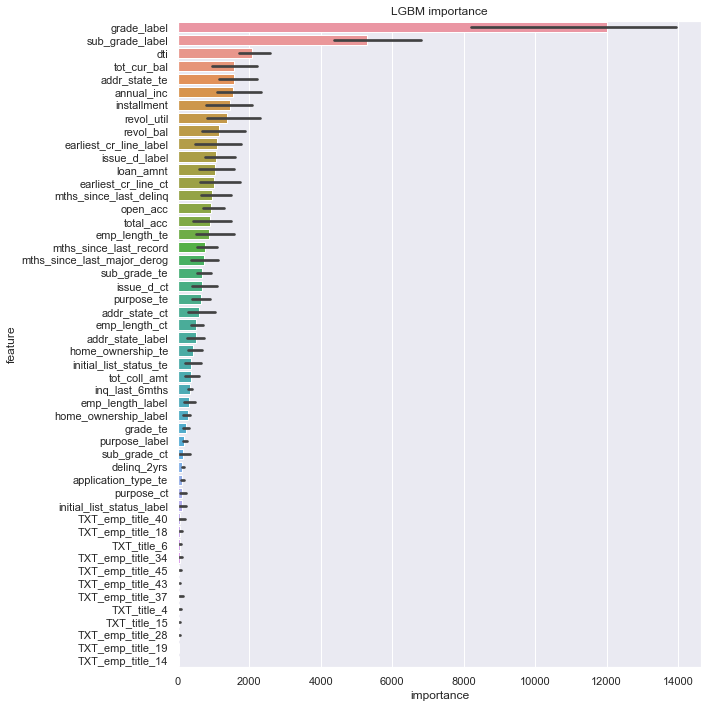

In [408]:
plot_lgbm(fold_models)

### submit

In [445]:
from datetime import datetime, timedelta, timezone
JST = timezone(timedelta(hours=9))
now = datetime.now(tz=JST)
now = now.strftime('%Y%m%d_%H%M') 

In [446]:
model = 'lgb'
submit= df_submit.copy()
submit[1] = y_preds_lgb
submit.to_csv(f'./submit_{model}_{now}.csv',header=None)
#df_y_preds_lgb =  submission.copy()

### やること

In [ ]:
### 回帰問題のligthtGBM,optuna,NNのモデル、map準備、特徴量生成のベース,merge関数